<img src="https://s3-sa-east-1.amazonaws.com/preditiva.ai/diversos/preditiva_assinatura.jpg">

# Métodos de Ensemble: *Blending*

## Importação das bibliotecas

In [1]:
# Pacotes de preparação dos dados
import pandas as pd
import numpy as np

# Pacotes gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes de modelagem
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Métricas de Desempenho
import preditiva

## Importação da base de dados

In [2]:
df = pd.read_csv('iris_original.csv')
df = df[df['Species'] != 'Iris-setosa']
df['Tipo_Orquidea'] = np.where(df['Species']=='Iris-virginica', 1, 0)
df.head()

Id  comprimento_sepala  largura_sepala  comprimento_petala  \
50  51                 7.0             3.2                 4.7   
51  52                 6.4             3.2                 4.5   
52  53                 6.9             3.1                 4.9   
53  54                 5.5             2.3                 4.0   
54  55                 6.5             2.8                 4.6   

    largura_petala          Species  Tipo_Orquidea  
50             1.4  Iris-versicolor              0  
51             1.5  Iris-versicolor              0  
52             1.5  Iris-versicolor              0  
53             1.3  Iris-versicolor              0  
54             1.5  Iris-versicolor              0

## Preparação dos Dados

### Missing Values

In [3]:
df.isnull().sum()

Id                    0
comprimento_sepala    0
largura_sepala        0
comprimento_petala    0
largura_petala        0
Species               0
Tipo_Orquidea         0
dtype: int64

### Duplicações

In [4]:
df.duplicated().sum()

0

### Tipos de Variáveis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 50 to 149
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  100 non-null    int64  
 1   comprimento_sepala  100 non-null    float64
 2   largura_sepala      100 non-null    float64
 3   comprimento_petala  100 non-null    float64
 4   largura_petala      100 non-null    float64
 5   Species             100 non-null    object 
 6   Tipo_Orquidea       100 non-null    int32  
dtypes: float64(4), int32(1), int64(1), object(1)
memory usage: 5.9+ KB


## Análise Exploratória dos Dados

### Dispersão por Classe

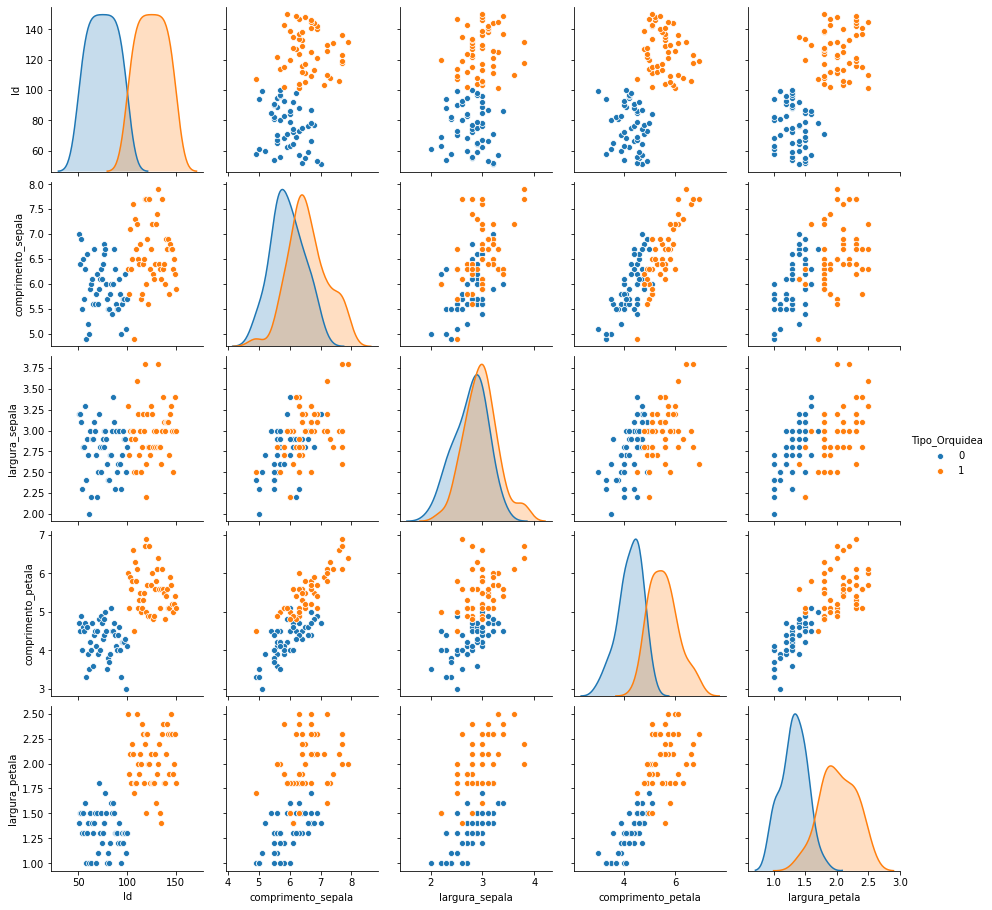

In [6]:
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')

sns.pairplot(df, hue='Tipo_Orquidea');

### Relatórios Pandas Profiling e SweetViz

In [ ]:
#perfil_pp, perfil_sv = preditiva.gera_relatorios_aed(df=df,
#                                                     target_feat='Tipo_Orquidea')
sns.reset_defaults()

## Desenvolvimento dos Modelos
Nesta etapa desenvolveremos 2 modelos para na sequencia fazermos um *blend* dos dois.

### Definição do *Target* e das *Features*

In [7]:
# Target (variável resposta)
y_var = 'Tipo_Orquidea'
y = df[y_var]

# Features (variáveis explicativas)
x1_var = ['comprimento_sepala', 'largura_sepala']
x1 = df[x1_var]

x2_var = ['comprimento_petala', 'largura_petala']
x2 = df[x2_var]

In [8]:
y.head()

50    0
51    0
52    0
53    0
54    0
Name: Tipo_Orquidea, dtype: int32

In [9]:
x1.head()

comprimento_sepala  largura_sepala
50                 7.0             3.2
51                 6.4             3.2
52                 6.9             3.1
53                 5.5             2.3
54                 6.5             2.8

In [10]:
x2.head()

comprimento_petala  largura_petala
50                 4.7             1.4
51                 4.5             1.5
52                 4.9             1.5
53                 4.0             1.3
54                 4.6             1.5

### Divisão das bases em Treino e Teste

In [11]:
x1_train, x1_test, y_train, y_test = train_test_split(x1, y, 
                                                      test_size=0.30,
                                                      random_state=42)

x2_train, x2_test, y_train, y_test = train_test_split(x2, y, 
                                                      test_size=0.30,
                                                      random_state=42)

In [12]:
x1_train.shape

(70, 2)

In [13]:
x2_train.shape

(70, 2)

In [14]:
x1_test.shape

(30, 2)

In [15]:
x2_test.shape

(30, 2)

### Modelo 1: Regressão Logística

In [16]:
# Ajuste do Modelo
modelo_rl = LogisticRegression(solver='lbfgs')
modelo_rl.fit(x1_train, y_train)

# Métricas de Desempenho
preditiva.calcula_desempenho(modelo_rl, x1_train, y_train, x1_test, y_test)

Treino     Teste  Variação
Acurácia   0.742857  0.733333     -0.01
AUROC      0.790336  0.798643      0.01
KS         0.541360  0.570136      0.05
Precision  0.743590  0.666667     -0.10
Recall     0.783784  0.769231     -0.02
F1         0.763158  0.714286     -0.06

### Modelo 2: Árvore de Decisão

In [17]:
# Treinamento do Modelo
modelo_ad = DecisionTreeClassifier(max_depth=3,
                                   min_samples_leaf=5)
modelo_ad.fit(x2_train, y_train)

# Métricas de Desempenho
preditiva.calcula_desempenho(modelo_ad, x2_train, y_train, x2_test, y_test)

Treino     Teste  Variação
Acurácia   0.971429  0.933333     -0.04
AUROC      0.997543  0.920814     -0.08
KS         0.939394  0.864253     -0.08
Precision  0.948718  0.923077     -0.03
Recall     1.000000  0.923077     -0.08
F1         0.973684  0.923077     -0.05

### Geração dos Scores dos Modelos 1 e 2 na base original

In [18]:
# Gerando os Scores dos Modelos 1 e 2
df['Prob_Predito_RL'] = modelo_rl.predict_proba(df[x1_var])[:,1]
df['Prob_Predito_AD'] = modelo_ad.predict_proba(df[x2_var])[:,1]

In [19]:
df.head()

Id  comprimento_sepala  largura_sepala  comprimento_petala  \
50  51                 7.0             3.2                 4.7   
51  52                 6.4             3.2                 4.5   
52  53                 6.9             3.1                 4.9   
53  54                 5.5             2.3                 4.0   
54  55                 6.5             2.8                 4.6   

    largura_petala          Species  Tipo_Orquidea  Prob_Predito_RL  \
50             1.4  Iris-versicolor              0         0.787165   
51             1.5  Iris-versicolor              0         0.595269   
52             1.5  Iris-versicolor              0         0.756886   
53             1.3  Iris-versicolor              0         0.237880   
54             1.5  Iris-versicolor              0         0.614267   

    Prob_Predito_AD  
50              0.0  
51              0.0  
52              0.0  
53              0.0  
54              0.0

### Separação da nova base em Treino e Teste

In [20]:
# Separação das variáveis explicativas e a variável target
y_var = 'Tipo_Orquidea'
y = df[y_var]

x_var_blend = ['Prob_Predito_RL','Prob_Predito_AD']
x_blend = df[x_var_blend]

# Divisão em treino e teste
x_blend_train, x_blend_test, y_blend_train, y_blend_test = train_test_split(x_blend, y, 
                                                                            test_size=0.30,
                                                                            random_state=42)

In [21]:
y.head()

50    0
51    0
52    0
53    0
54    0
Name: Tipo_Orquidea, dtype: int32

In [22]:
x_blend_train.head()

Prob_Predito_RL  Prob_Predito_AD
61          0.396577              0.0
97          0.505692              0.0
135         0.912667              1.0
78          0.429325              0.0
143         0.731165              1.0

### Blending dos Modelos usando Árvore de Decisão

In [23]:
# Treinamento do Modelo
modelo_blend = DecisionTreeClassifier(max_depth=3, 
                                      min_samples_leaf=5)
modelo_blend.fit(x_blend_train, y_blend_train)

# Métricas de Desempenho: Modelo Blend
preditiva.calcula_desempenho(modelo_blend, x_blend_train, y_blend_train, x_blend_test, y_blend_test)

Treino     Teste  Variação
Acurácia   0.971429  0.933333     -0.04
AUROC      0.997543  0.920814     -0.08
KS         0.939394  0.864253     -0.08
Precision  0.948718  0.923077     -0.03
Recall     1.000000  0.923077     -0.08
F1         0.973684  0.923077     -0.05

### Comparação com Modelos Iniciais

In [24]:
# Desempenho do Modelo 1: Regressão Logística
preditiva.calcula_desempenho(modelo_rl, x1_train, y_train, x1_test, y_test)

Treino     Teste  Variação
Acurácia   0.742857  0.733333     -0.01
AUROC      0.790336  0.798643      0.01
KS         0.541360  0.570136      0.05
Precision  0.743590  0.666667     -0.10
Recall     0.783784  0.769231     -0.02
F1         0.763158  0.714286     -0.06

In [25]:
# Desempenho do Modelo 2: Árvore de Decisão
preditiva.calcula_desempenho(modelo_ad, x2_train, y_train, x2_test, y_test)

Treino     Teste  Variação
Acurácia   0.971429  0.933333     -0.04
AUROC      0.997543  0.920814     -0.08
KS         0.939394  0.864253     -0.08
Precision  0.948718  0.923077     -0.03
Recall     1.000000  0.923077     -0.08
F1         0.973684  0.923077     -0.05